# Train XGBoost model

In [1]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from pathlib import Path

In [2]:
import xgboost as xgb

In [3]:
import os
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/hh_micro_mono/")
os.chdir(root_dir / "DMR_classifier")

In [4]:
adata = sc.read_h5ad("chrom5k-ct_subset-hypo_score-binarized.h5ad")
metadata = pd.read_csv("dmr_regions-CGN_hypo_score-meta_sub.tsv", sep="\t", header=0, index_col=0)

In [5]:
included_ct = [
    "CA", "DG", "SUB", "PVALB", "SST", "VIP", "NR2F2-LAMP5",
    "Astro", "Oligo", "OPC", "Endo-VLMC",
    "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    "NK_CD16_Bld", "Tnaive_CD4_1", "infant_MGC-1"
]

In [6]:
adata = adata[metadata[metadata["celltype"].isin(included_ct)].index, :]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 5683 × 192951
    obs: 'allc_path', 'celltype', 'total_cov', 'assay', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [8]:
X = adata.obsm["X_harmony"]
y = metadata.loc[adata.obs_names, "celltype"].values
le = LabelEncoder()
y_numeric = le.fit_transform(y)

In [9]:
# Train: Eval: Test in 7:2:1 ratio
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_numeric, test_size=0.1, random_state=42, stratify=y_numeric
)
X_train, X_eval, y_train, y_eval = train_test_split(
    X_temp, y_temp, test_size=2/9, random_state=42, stratify=y_temp
)

In [10]:
# Load data onto XGBoost GPU support
dtrain = xgb.DMatrix(X_train, label=y_train)
deval = xgb.DMatrix(X_eval, label=y_eval)
dtest = xgb.DMatrix(X_test, label=y_test)

In [11]:
## Accuracy calculation
num_classes = len(np.unique(y_numeric))
def accuracy_eval(preds, dmatrix):
    labels = dmatrix.get_label().astype(int)
    preds = preds.reshape(-1, num_classes)
    pred_labels = np.argmax(preds, axis=1)
    acc = np.mean(pred_labels == labels)
    return "accuracy", acc

In [12]:
print(num_classes)

18


In [13]:
print(len(metadata["celltype"].unique()))

30


## Training

In [15]:
params = {
    "objective": "multi:softprob",
    "num_class": num_classes,
    "tree_method": "hist",
    "device": "cuda",
    "max_depth": 5,
    "learning_rate": 0.1,
    "subsample": 1,
    "colsample_bytree": 0.8,
    "reg_lambda": 1.0,
    "reg_alpha": 0.5,
    "eval_metric": "mlogloss",
    "random_state": 42
}

In [16]:
evals = [(dtrain, "train"), (deval, "eval")]
evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=evals,
    custom_metric=accuracy_eval,
    evals_result=evals_result,
    early_stopping_rounds=300,
    verbose_eval=20
)

[0]	train-mlogloss:2.18332	train-accuracy:0.95474	eval-mlogloss:2.20910	eval-accuracy:0.91909
[20]	train-mlogloss:0.27135	train-accuracy:0.99447	eval-mlogloss:0.37461	eval-accuracy:0.96834
[40]	train-mlogloss:0.06269	train-accuracy:0.99799	eval-mlogloss:0.15505	eval-accuracy:0.97537
[60]	train-mlogloss:0.02324	train-accuracy:0.99975	eval-mlogloss:0.10474	eval-accuracy:0.97713
[80]	train-mlogloss:0.01342	train-accuracy:1.00000	eval-mlogloss:0.09047	eval-accuracy:0.97537
[100]	train-mlogloss:0.00988	train-accuracy:1.00000	eval-mlogloss:0.08469	eval-accuracy:0.97625
[120]	train-mlogloss:0.00823	train-accuracy:1.00000	eval-mlogloss:0.08194	eval-accuracy:0.97625
[140]	train-mlogloss:0.00734	train-accuracy:1.00000	eval-mlogloss:0.08028	eval-accuracy:0.97537
[160]	train-mlogloss:0.00681	train-accuracy:1.00000	eval-mlogloss:0.07923	eval-accuracy:0.97537
[180]	train-mlogloss:0.00654	train-accuracy:1.00000	eval-mlogloss:0.07873	eval-accuracy:0.97537
[200]	train-mlogloss:0.00639	train-accuracy:1.

In [17]:
eval_logloss = evals_result["eval"]["mlogloss"]
best_iter = int(np.argmin(eval_logloss))
print(best_iter)
best_score = float(np.min(eval_logloss))

285


In [18]:
bst.save_model("models/chrom5k-hypo_score-harmony-20251015.json")

## After training

In [14]:
bst = xgb.Booster()
bst.load_model("models/chrom5k-hypo_score-harmony-20251015.json")

In [15]:
best_iter = 285
y_pred_proba = bst.predict(dtest, iteration_range=(0, best_iter + 1))
y_pred = np.argmax(y_pred_proba, axis=1)

In [16]:
order = included_ct

In [17]:
np.sum(y_test == y_pred) / len(y_test)

0.9718804920913884

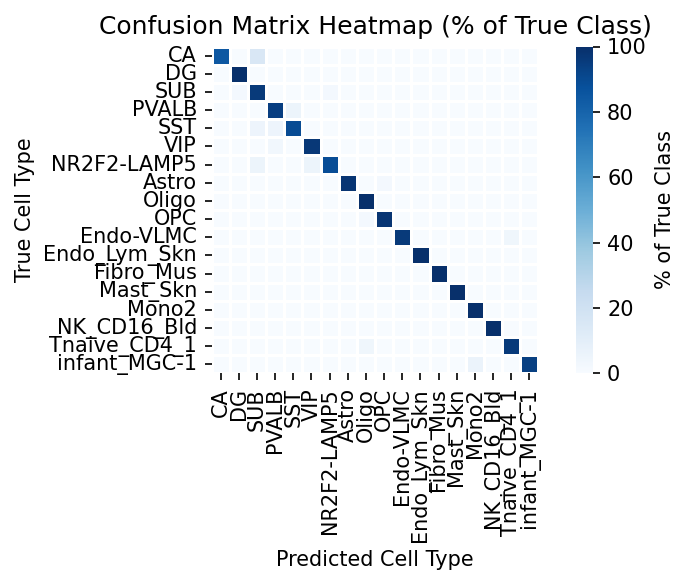

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# Create heatmap
cm = confusion_matrix(y_test, y_pred, normalize="true") * 100
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df = cm_df.loc[order, order]
plt.figure(figsize=(6, 4), dpi=150)
sns.heatmap(
    cm_df,
    cmap="Blues",
    cbar_kws={"label": "% of True Class"},
    square=True,
    annot=False,
    linewidths=0.5
)

plt.title("Confusion Matrix Heatmap (% of True Class)")
plt.xlabel("Predicted Cell Type")
plt.ylabel("True Cell Type")
plt.tight_layout()
plt.savefig("results/chrom5k-hypo_score_binarized-harmony-confusion_matrix.pdf")

In [23]:
adata = sc.read_h5ad("chrom5k-ct_subset-hypo_score-binarized.h5ad")
micro_adata = adata[adata.obs["celltype"].isin(["Micro1", "Micro2"]), :].copy()

In [24]:
micro_adata

AnnData object with n_obs × n_vars = 2634 × 192951
    obs: 'allc_path', 'celltype', 'total_cov', 'assay', 'leiden'
    var: 'chrom', 'end', 'start'
    uns: 'leiden', 'leiden_sizes', 'neighbors', 'paga', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [25]:
dmicro = xgb.DMatrix(micro_adata.obsm["X_harmony"])

In [26]:
micro_pred_prob = bst.predict(dmicro, iteration_range=(0, best_iter + 1))
micro_pred = np.argmax(micro_pred_prob, axis=1)

In [27]:
pred_df = pd.DataFrame({
    "cell_id": micro_adata.obs_names,
    "true_type": micro_adata.obs["celltype"],
    "predicted_type": le.inverse_transform(micro_pred),
})

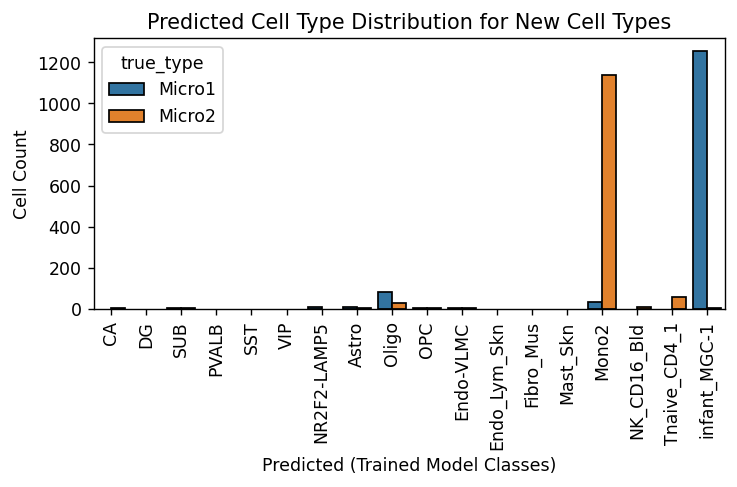

In [28]:
plt.figure(figsize=(6, 4), dpi=125)
sns.countplot(data=pred_df, x="predicted_type", hue="true_type", order=order, edgecolor="black")
plt.title("Predicted Cell Type Distribution for New Cell Types")
plt.xlabel("Predicted (Trained Model Classes)")
plt.ylabel("Cell Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [29]:
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
# proba_df = pd.DataFrame(
#     gaussian_filter1d(micro_pred_prob, sigma=1, axis=1, mode="nearest"),
#     columns=le.classes_,
#     index=micro_adata.obs_names
# )
proba_df = pd.DataFrame(micro_pred_prob, columns=le.classes_)
proba_df["celltype"] = micro_adata.obs["celltype"].values
proba_df["cell_id"] = micro_adata.obs_names.values
proba_long = proba_df.melt(
    id_vars=["cell_id", "celltype"],
    var_name="predicted_class",
    value_name="probability"
)
proba_long["predicted_class"] = pd.Categorical(proba_long["predicted_class"], categories=order)

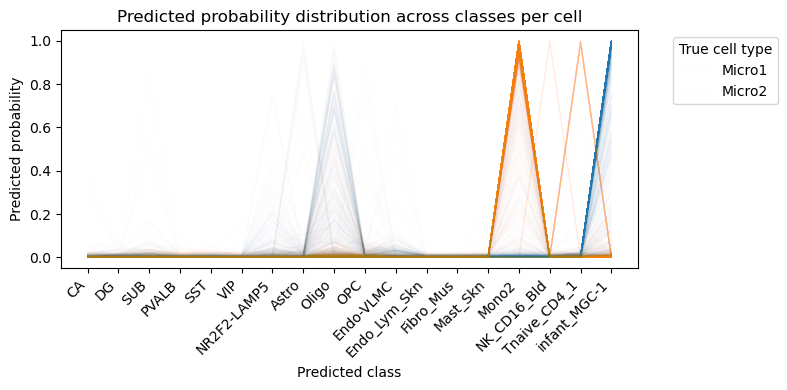

In [31]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=proba_long,
    x="predicted_class",
    y="probability",
    hue="celltype",
    units="cell_id",
    estimator=None,
    lw=1,
    alpha=0.01,
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted probability")
plt.xlabel("Predicted class")
plt.title("Predicted probability distribution across classes per cell")
plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [32]:
meta_raw = pd.read_csv("allc_meta.tsv", sep="\t", header=0, index_col=0)

In [33]:
entropy = -np.sum(micro_pred_prob * np.log(micro_pred_prob + 1e-12), axis=1)
entropy /= np.log(micro_pred_prob.shape[1])
sorted_prob = np.sort(micro_pred_prob, axis=1)
margin = sorted_prob[:, -1] - sorted_prob[:, -2]
proba_max_value = pd.DataFrame({
    "max_value": np.max(micro_pred_prob, axis=1),
    "entropy": entropy,
    "margin": margin,
    "celltype": micro_adata.obs["celltype"].values,
    "prediction": le.inverse_transform(micro_pred),
    "cell_id": micro_adata.obs_names,
    "cov": meta_raw.loc[micro_adata.obs_names, "total_cov"]
})

In [34]:
confident_cells = proba_max_value[proba_max_value["cov"] >= 0.7e5]["cell_id"]

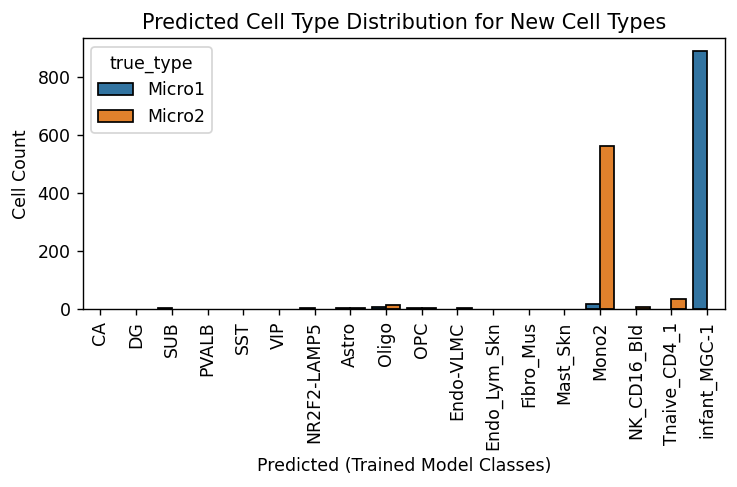

In [35]:
plt.figure(figsize=(6, 4), dpi=125)
sns.countplot(
    data=pred_df[pred_df["cell_id"].isin(confident_cells)], 
    x="predicted_type", 
    hue="true_type", 
    order=order, 
    edgecolor="black"
)
plt.title("Predicted Cell Type Distribution for New Cell Types")
plt.xlabel("Predicted (Trained Model Classes)")
plt.ylabel("Cell Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

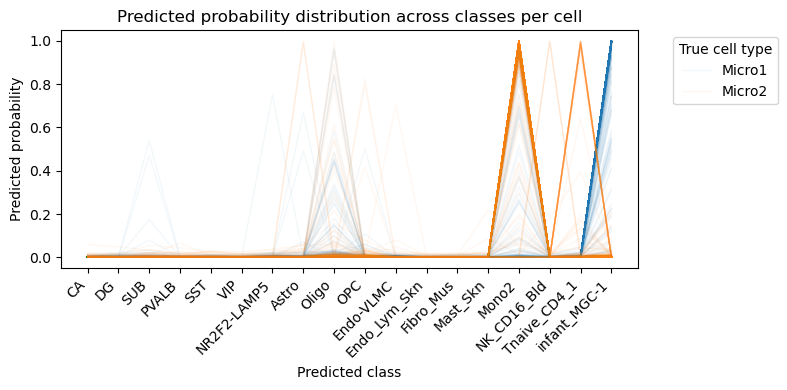

In [36]:
plt.figure(figsize=(8, 4))
sns.lineplot(
    data=proba_long[proba_long["cell_id"].isin(confident_cells)],
    x="predicted_class",
    y="probability",
    hue="celltype",
    units="cell_id",
    estimator=None,
    lw=1,
    alpha=0.05,
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Predicted probability")
plt.xlabel("Predicted class")
plt.title("Predicted probability distribution across classes per cell")
plt.legend(title="True cell type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [37]:
pred_df.to_csv(
    "results/chrom5k-hypo_score-harmony-20251015-micro_subtype-prediction.tsv",
    sep="\t", header=True, index=True
)

In [38]:
df = proba_long.copy()
df.to_csv("results/chrom5k-hypo_score-harmony-20251015-micro_subtype-pred_prob.tsv", sep="\t", header=True, index=True)

# Plot important regions

In [5]:
bst = xgb.Booster()
bst.load_model("models/trinarize_20251013.json")

In [6]:
importance = bst.get_score(importance_type="gain")
importance_df = (
    pd.DataFrame(list(importance.items()), columns=["feature", "importance"])
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

In [7]:
importance_df.shape

(51847, 2)

In [8]:
topN = int(importance_df.shape[0] * 0.01)
importance_df["region"] = [adata.var_names[int(f[1:])] for f in importance_df["feature"]]
top_regions = importance_df["region"].head(topN).values

In [9]:
metadata = pd.read_csv("allc_meta.tsv", sep="\t", header=0, index_col=0)
metadata["ct_raw"] = metadata["celltype"].copy()
ext = ["CA", "DG", "SUB"]
metadata.loc[metadata["celltype"].isin(ext), "celltype"] = "Exc_Neurons"
inh = ["PVALB", "SST", "VIP", "NR2F2-LAMP5"]
metadata.loc[metadata["celltype"].isin(inh), "celltype"] = "Inh_Neurons"

In [10]:
from ALLCools.mcds import MCDS

In [11]:
mcds_path = "DMR_CLS.mcds"
var_dim = "dmr_regions"
obs_dim = "cell"
mcds = MCDS.open(mcds_path, obs_dim=obs_dim, var_dim=var_dim)
mcds.add_cell_metadata(metadata)

In [12]:
included_ct = [
    "Exc_Neurons", "Inh_Neurons",
    "Astro", "Oligo", "OPC", "Endo-VLMC",
    "Endo_Lym_Skn", "Fibro_Mus", "Mast_Skn", "Mono2",
    "NK_CD16_Bld", "Tnaive_CD4_1", "infant_MGC-1"
]

In [13]:
order = included_ct

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

In [15]:
top_regions = top_regions[np.argsort([int(xx.split("_")[-1]) for xx in top_regions])]

In [16]:
da = mcds["dmr_regions_da"]
mc = da.sel(mc_type="CGN", count_type="mc")
cov = da.sel(mc_type="CGN", count_type="cov")
mc_bulk = mc.groupby("cell_celltype").sum(dim="cell")
cov_bulk = cov.groupby("cell_celltype").sum(dim="cell")
bulk_beta_sel = 1.0 - mc_bulk.sel(dmr_regions=top_regions) / cov_bulk.sel(dmr_regions=top_regions)

In [17]:
bulk_beta_sel = bulk_beta_sel.to_pandas()

In [32]:
order = included_ct
order = order + ["Micro1", "Micro2"]
df_beta = bulk_beta_sel[bulk_beta_sel.index.isin(order)]
# df_beta = df_beta.loc[order, sorted_columns]
region_order = df_beta.idxmax(axis=0)
region_order = pd.Categorical(region_order, categories=order, ordered=True)
df_beta = df_beta.iloc[:, np.argsort(region_order.codes)]
df_beta = df_beta.loc[order, :]
df_beta_z = (df_beta - df_beta.mean()) / df_beta.std()

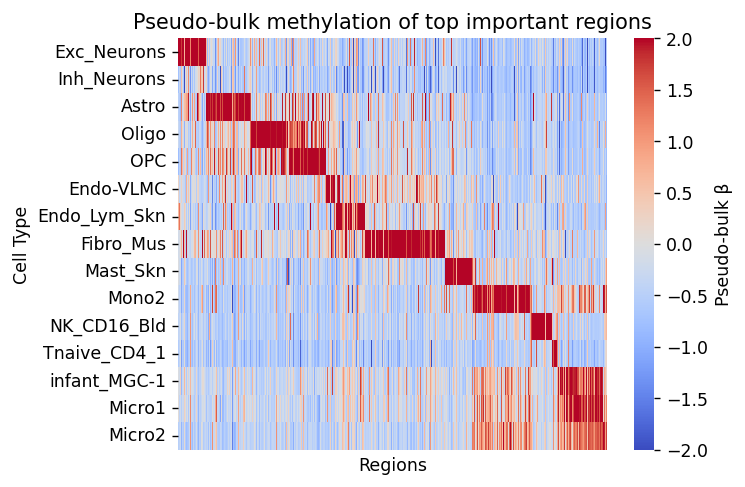

In [35]:
plt.figure(figsize=(6, 4), dpi=125)
sns.heatmap(
    df_beta_z,
    cmap="coolwarm",
    center=0,
    xticklabels=False,
    vmin=-2, 
    vmax=2,
    cbar_kws={"label": "Pseudo-bulk β"},
)
plt.xlabel("Regions")
plt.ylabel("Cell Type")
plt.title("Pseudo-bulk methylation of top important regions")
plt.tight_layout()
plt.show()